<h1> How to do NLP-like research in physics


This notebook provides a step-by-step demonstration/tutorial based on the Lagrangian paper.

# Acknowledge SUPR

The computations and data handling were enabled by resources provided by the National Academic Infrastructure for Supercomputing in Sweden (NAISS) from projects ????, partially funded by the Swedish Research Council through grant agreement no. 2022-06725

# Libraries

In [1]:
import lag_eval as le

2025-04-09 11:22:51.242918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 11:22:51.285930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 11:22:52.253318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Checking Tokens Format
particle_id_token          :  ['ID1']
derivative_id_token        :  ['ID1']
gamma_id_token             :  ['ID1']
sigma_id_token(1)          :  ['ID1']
spin_token(0)              :  ['SPIN', '0']
spin_token(1)              :  ['SPIN', '1']
spin_token(Fraction(1,2))  :  ['SPIN', '1/2']
helicity_token(1)          :  ['HEL', '1/2']
helicity_token(-1)         :  ['HEL', '-1/2']
group_tokens(1)            :  ['U1']
group_tokens(1,test)            :  ['U1', '_{test}']
group_tokens(2)            :  ['SU2']
group_tokens(2,test)            :  ['SU2', '_{test}']
group_tokens(3)            :  ['SU3']
group_tokens(3,test)            :  ['SU3', '_{test}']
Tokens Format OK


# Models
- Overview of HuggingFace library.
- How to find off-the-shelf transformer models (e.g., BART-L).
- Example usage of a HuggingFace model.

## HuggingFace Library

In [2]:
# # Import HuggingFace libraries
# from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# # Load a pre-trained model and tokenizer (e.g., BART-small)
# # Note: You can change the model name to any other Seq2Seq model available on HuggingFace
# # Model name can be changed to any other Seq2Seq model available on HuggingFace
# # For example: 'facebook/bart-base', 't5-small', etc.

# # 'facebook/bart-base' : BART model with 140M parameters
# # 'facebook/bart-large' : BART model with 406M parameters
# # 't5-small' : T5 model with 60M parameters

# model_name = 'facebook/bart-base'
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Example usage
# text = "This is a sample input."
# inputs = tokenizer(text, return_tensors="pt")
# outputs = model.generate(**inputs)
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

# Dataset
- Discussion on data generation considerations:
  - Data distribution.
  - Tokenization choices.
- Example of tokenizing a dataset.

## Data Distribution


Show plots from paper:
- one from random ->  more equal better at long expression
- one from smart  ->  more biased (cover edge terms) better at special cases

In [4]:
import pandas as pd

sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")


In [5]:
sampled_df["nfields"] = sampled_df["fields"].apply(lambda x: x.count("FIELD"))
sampled_df["nfermions"] = sampled_df["fields"].apply(lambda x: x.count("SPIN 1"))
sampled_df["nscalars"] = sampled_df["fields"].apply(lambda x: x.count("SPIN 0"))

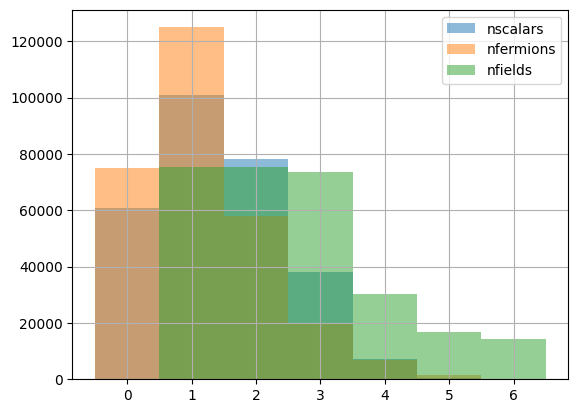

In [6]:
import matplotlib.pyplot as plt
sampled_df["nscalars"].hist(  range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nscalars") 
sampled_df["nfermions"].hist( range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nfermions") 
sampled_df["nfields"].hist(   range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nfields") 
plt.legend()

## Tokenization choices
Considerations: 
- What information is required for your model to learn?
- Do you care about expressivity? 

Practical 
- How much information?
- Vocabulary Size?

### Choices of Tokenization

In Language:
Example Phrase : AI For Physics
- Word-Level : AI, For, Physics
- Character-Level : A, I,  , F, o, r,  , P, h, y, s, i, c, s

In Math:
Example Expression : 100 + 420 = 520
- "Term"-level : 100, +, 420, =, 520
- "Digit"-Level : 1, 0, 0,  +,  4, 2, 0, =,  5, 2, 0

In Lagrangians:
Example Field : Higgs Particle
- Symbol Level : H
- Quantum-Numbers-Level: FIELD, SPIN, 0, SU2, 2, U1, 1



Remark: 
1. Detailed tokenization : 
- less vocabulary
- more expressive
- more token per sequence
- heavy on attention mechanism
2. Coarse tokenization : 
- more vocabulary
- less expressive
- less token per sequence
- easier on attention mechanism

### Example : Math 

In [7]:
import random 
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Character-level 
# 1. Generate arithmetic corpus
char_level_corpus = [" ".join(list(f"{a}+{b}={str(a + b)}")) for a in range(100) for b in range(100)]
vocab = {"1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9,
         "0" : 0, "+" : 10, "=" : 11,"[UNK]" : 12, "[PAD]" : 13, "[BOS]" : 14, "[EOS]" : 15}
# 2. Initialize tokenizer components
char_level_tokenizer = Tokenizer(WordLevel(vocab=vocab, unk_token="[UNK]"))
char_level_tokenizer.pre_tokenizer = Whitespace()


# Word-level 
word_level_corpus = [f"{a} + {b} = {str(a + b)}" for a in range(100) for b in range(100)]
word_level_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
word_level_tokenizer.pre_tokenizer = Whitespace()
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
trainer = WordLevelTrainer(special_tokens=special_tokens)
word_level_tokenizer.train_from_iterator(word_level_corpus, trainer)



lets see it in action

In [8]:
char_level_example = random.choice(char_level_corpus)
print("char_level_example : ",char_level_example)
print("char_level_tokens  : ",char_level_tokenizer.encode(char_level_example).tokens,end="\n\n")

word_level_example = random.choice(word_level_corpus)
print("word_level_example : ",word_level_example)
print("word_level_tokens  : ",word_level_tokenizer.encode(word_level_example).tokens,end="\n\n")

char_level_example :  2 7 + 2 8 = 5 5
char_level_tokens  :  ['2', '7', '+', '2', '8', '=', '5', '5']

word_level_example :  27 + 99 = 126
word_level_tokens  :  ['27', '+', '99', '=', '126']



Lets check vocab size

In [9]:
print("char_level_vocab_size: ",char_level_tokenizer.get_vocab_size())
print("word_level_vocab_size: ",word_level_tokenizer.get_vocab_size())

char_level_vocab_size:  16
word_level_vocab_size:  205


Try encoding 10000

In [10]:
OOD_char_level_example =   "1 0 0 0 0"
print("char_level_tokens  : ",char_level_tokenizer.encode(OOD_char_level_example).tokens,end="\n\n")

OOD_word_level_example =   "10000"
print("word_level_tokens  : ",word_level_tokenizer.encode(OOD_word_level_example).tokens,end="\n\n")

# Something like this is possible but not intuitive (words and number are slightly different)
OOD_word_level_example =   "10 0 0 0"
print("word_level_tokens  : ",word_level_tokenizer.encode(OOD_word_level_example).tokens,end="\n\n")

char_level_tokens  :  ['1', '0', '0', '0', '0']

word_level_tokens  :  ['[UNK]']

word_level_tokens  :  ['10', '0', '0', '0']



### Example : Fields 

In [11]:
from transformers import  PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast.from_pretrained("JoseEliel/BART-Lagrangian")

example = sampled_df.sample(1)["fields"].values[0]
print("Input    = ",example)
encoded = hf_tokenizer.encode(example)
print("token_id = ", encoded)
decoded = hf_tokenizer.decode(encoded)
print("decoded  = ", decoded)


Input    =  FIELD SPIN 1/2 SU3 3 U1 - 2 / 7 HEL -1/2
token_id =  [22, 36, 5, 4, 6, 38, 10, 39, 7, 6, 4, 14, 23, 7, 5, 4, 6]
decoded  =  FIELD SPIN 1 / 2 SU3 3 U1 - 2 / 7 HEL - 1 / 2


# Training
- Mention available resources: SUPR/NAISS -> Alvis.
- Example of training a model.

### NAISS : https://www.naiss.se/
### SUPR : https://supr.naiss.se/
### Alvis : https://www.c3se.chalmers.se/about/Alvis/
### OnDemand Portal : https://alvis.c3se.chalmers.se/pun/sys/dashboard/

## CPU or GPU

In [2]:
# Choose GPU if available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Evaluation
- Generating output from the model.
- Discussion on evaluation choices:
  - Existing or novel metrics.
  - Embedding analysis.
  - Out-of-distribution tests.

## Existing Metric  : Does it work? 

mainly to see if things work as expected
Loss : Deviation from actual term 
Accuracy : How much is perfect? 
New metric, Score : (Order does not always matter, XEN)

In [116]:
import torch
import lag_eval as le
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

model_name = "JoseEliel/BART-Lagrangian"
model = BartForConditionalGeneration.from_pretrained(model_name)
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)


In [13]:
sampled_df.drop_duplicates(subset=["fields"], inplace=True)

In [14]:
sampled_df

,fields,Lagrangian,train/eval,nfields,nfermions,nscalars
0,FIELD SPIN 1/2 SU3 - 3 SU2 2 U1 - 4 HEL 1/2 FI...,+ FIELD SPIN 1 / 2 SU3 - 3 SU2 2 HEL - 1 / 2 D...,eval,3,2,1
1,FIELD SPIN 1/2 HEL 1/2 FIELD SPIN 1/2 SU3 - 3 ...,+ i FIELD SPIN 1 / 2 HEL 1 / 2 ID9 SIGMA_BAR I...,eval,2,2,0
2,FIELD SPIN 0 SU2 3 U1 - 4 / 9 FIELD SPIN 1/2 S...,+ FIELD SPIN 0 SU2 3 U1 - 4 / 9 ID1 FIELD SPIN...,eval,4,2,2
3,FIELD SPIN 1/2 SU3 - 3 U1 3 / 8 HEL -1/2 FIELD...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 8 / 9 ID3 FI...,eval,5,4,1
4,FIELD SPIN 0 SU3 3 SU2 3,+ FIELD SPIN 0 SU3 3 SU2 3 ID4 FIELD SPIN 0 SU...,eval,1,0,1
...,...,...,...,...,...,...
286076,FIELD SPIN 0 SU3 3 SU2 3 U1 9 / 2 FIELD SPIN 1...,+ FIELD SPIN 1 / 2 SU2 2 U1 1 / 5 HEL - 1 / 2 ...,train,4,1,3
286077,FIELD SPIN 0 FIELD SPIN 0 SU3 3 SU2 3 U1 7 / 6...,+ FIELD SPIN 0 ID1 FIELD SPIN 0 SU3 3 SU2 3 U1...,train,3,1,2
286078,FIELD SPIN 0 SU3 - 3 U1 3 FIELD SPIN 1/2 SU3 3...,+ FIELD SPIN 0 SU3 - 3 U1 3 ID4 FIELD SPIN 0 S...,train,3,1,2
286079,FIELD SPIN 1/2 U1 - 4 / 5 HEL -1/2 FIELD SPIN ...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 / 7 ID6 FI...,train,2,1,1


In [95]:
example_scenario = sampled_df.sample(1)


In [103]:
example = example_scenario["fields"].values[0]
example_input = "[SOS] " + example + " [EOS]"
print("Input    = ",example_input)
encoded_input = hf_tokenizer.encode(example_input)
print("token_id = ", encoded_input)
decoded_input = hf_tokenizer.decode(encoded_input)
print("decoded  = ", decoded_input)


Input    =  [SOS] FIELD SPIN 1/2 U1 1 / 2 HEL -1/2 FIELD SPIN 0 SU3 3 SU2 2 U1 1 FIELD SPIN 0 SU3 3 U1 - 2 [EOS]
token_id =  [0, 22, 36, 5, 4, 6, 39, 5, 4, 6, 23, 7, 5, 4, 6, 22, 36, 9, 38, 10, 37, 6, 39, 5, 22, 36, 9, 38, 10, 39, 7, 6, 1]
decoded  =  [SOS] FIELD SPIN 1 / 2 U1 1 / 2 HEL - 1 / 2 FIELD SPIN 0 SU3 3 SU2 2 U1 1 FIELD SPIN 0 SU3 3 U1 - 2 [EOS]


In [104]:
example = example_scenario["Lagrangian"].values[0]
example_output = "[SOS] " + example + " [EOS]"
print("Output   = ",example_output)
encoded_output = hf_tokenizer.encode(example_output)
print("token_id = ", encoded_output)
decoded_output = hf_tokenizer.decode(encoded_output)
print("decoded  = ", decoded_output)


Output   =  [SOS] + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID4 CONTRACTIONS SU3 ID9 ID7 ID4 SU2 ID9 ID7 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID9 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID1 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID8 CONTRACTIONS SU3 ID9 ID9 ID1 SU3 ID1 ID8 ID8 SU2 ID9 ID1 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID2 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID1 CONTRACTIONS SU3 ID5 ID2 ID3 SU3 ID2 ID1 ID1 SU2 ID5 ID2 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID6 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID5 CONTRACTIONS SU3 ID6 ID7 ID7 SU3 ID3 ID5 ID5 SU2 ID6 ID7 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID0 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID8 CONTRACTIONS SU3 ID9 ID0 ID0 SU3 ID2 ID8 ID8 SU2 ID9 ID0 SU2 ID2 ID8 + FIELD SPIN 0 S

In [105]:
# show the terms 
separated_terms = le.sep_terms(decoded_output)

for i in range(len(separated_terms)):
    print(f"term {i} : "," ".join(separated_terms[i]))

lag_truth_1 =  " ".join([" ".join(i) for i in separated_terms])

print()
# reorder the first and second terms using list 
separated_terms[0],separated_terms[1] = separated_terms[1],separated_terms[0]
for i in range(len(separated_terms)):
    print(f"term {i} : "," ".join(separated_terms[i]))
lag_truth_2 =  " ".join([" ".join(i) for i in separated_terms])


term 0 :  + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID4 CONTRACTIONS SU3 ID9 ID7 ID4 SU2 ID9 ID7
term 1 :  + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID9 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID1 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID8 CONTRACTIONS SU3 ID9 ID9 ID1 SU3 ID1 ID8 ID8 SU2 ID9 ID1
term 2 :  + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID2 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID1 CONTRACTIONS SU3 ID5 ID2 ID3 SU3 ID2 ID1 ID1 SU2 ID5 ID2
term 3 :  + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID6 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID5 CONTRACTIONS SU3 ID6 ID7 ID7 SU3 ID3 ID5 ID5 SU2 ID6 ID7
term 4 :  + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID0 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID8 CONTRACTIONS SU3 ID9 ID0 ID0 SU3 ID2 ID8 ID8 SU2 ID9 

In [106]:
print("lag_truth_1 : ",lag_truth_1)
print("lag_truth_2 : ",lag_truth_2)


lag_truth_1 :  + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID4 CONTRACTIONS SU3 ID9 ID7 ID4 SU2 ID9 ID7 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID9 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID1 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID8 CONTRACTIONS SU3 ID9 ID9 ID1 SU3 ID1 ID8 ID8 SU2 ID9 ID1 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID2 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID1 CONTRACTIONS SU3 ID5 ID2 ID3 SU3 ID2 ID1 ID1 SU2 ID5 ID2 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID6 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID5 CONTRACTIONS SU3 ID6 ID7 ID7 SU3 ID3 ID5 ID5 SU2 ID6 ID7 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID0 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID8 CONTRACTIONS SU3 ID9 ID0 ID0 SU3 ID2 ID8 ID8 SU2 ID9 ID0 SU2 ID2 ID8 + FIELD SPIN 0 SU3 

In [ ]:
 
targets_1 = hf_tokenizer("[SOS] " + lag_truth_1 + " [EOS]", return_tensors="pt", truncation=True, padding=True)
targets_2 = hf_tokenizer("[SOS] " + lag_truth_2 + " [EOS]", return_tensors="pt", truncation=True, padding=True)

#print("targets_1:\n", targets_1)
labels_1 = targets_1["input_ids"]
#print("targets_2:\n", targets_2)
labels_2 = targets_2["input_ids"]


#print("inputs:\n", encoded_input)
print("inputs:\n", hf_tokenizer.decode(encoded_input))
#print("labels_1:\n", labels_1)
print("labels_1:\n", hf_tokenizer.decode(labels_1[0]))
#print("labels_2:\n", labels_2)
print("labels_2:\n", hf_tokenizer.decode(labels_2[0]))


with torch.no_grad():
    # loss with labels_1 and labels_2
    outputs_1 = model(input_ids=torch.tensor(encoded_input).unsqueeze(0), labels=labels_1)
    print("loss with labels_1:", outputs_1.loss)
    # Get the predicted token IDs by taking the argmax over the vocabulary dimension
    predicted_token_ids_1 = torch.argmax(outputs_1.logits, dim=-1)  # Shape: [batch_size, seq_len]

    # Decode the predicted token IDs to get the predicted string
    predicted_string_1 = hf_tokenizer.decode(predicted_token_ids_1[0], skip_special_tokens=True)
    
    outputs_2 = model(input_ids=torch.tensor(encoded_input).unsqueeze(0), labels=labels_2)
    print("loss with labels_2:", outputs_2.loss)
    # Get the predicted token IDs by taking the argmax over the vocabulary dimension
    predicted_token_ids_2 = torch.argmax(outputs_2.logits, dim=-1)  # Shape: [batch_size, seq_len]
    
    # Decode the predicted token IDs to get the predicted string
    predicted_string_2 = hf_tokenizer.decode(predicted_token_ids_2[0], skip_special_tokens=True)

    
    
    # prediction during inference
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).unsqueeze(0), max_length=len(labels_1[0]))
    predicted_string = hf_tokenizer.decode(generated_id[0], skip_special_tokens=True)
    

inputs:
 [SOS] FIELD SPIN 1 / 2 U1 1 / 2 HEL - 1 / 2 FIELD SPIN 0 SU3 3 SU2 2 U1 1 FIELD SPIN 0 SU3 3 U1 - 2 [EOS]
labels_1:
 [SOS] + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID4 CONTRACTIONS SU3 ID9 ID7 ID4 SU2 ID9 ID7 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID9 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID1 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID8 CONTRACTIONS SU3 ID9 ID9 ID1 SU3 ID1 ID8 ID8 SU2 ID9 ID1 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID2 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID1 CONTRACTIONS SU3 ID5 ID2 ID3 SU3 ID2 ID1 ID1 SU2 ID5 ID2 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID6 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID5 CONTRACTIONS SU3 ID6 ID7 ID7 SU3 ID3 ID5 ID5 SU2 ID6 ID7 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID0 FIELD SPIN 0 SU3

In [146]:
lscore_1, obscore_1, conscore_1, lpen_1 = le.get_lagrangian_score(predicted_string,lag_truth_1)
lscore_2, obscore_2, conscore_2, lpen_2 = le.get_lagrangian_score(predicted_string,lag_truth_2)

print("predicted_string  : ", predicted_string)
print()
print("lag_truth_1       : ", lag_truth_1)
print("lagrangian score  : ",lscore_1)
print("Object score      : ",obscore_1)
print("Contraction Score : ",conscore_1)
print("Length penalty    : ",lpen_1)
print()
print("lag_truth_2       : ", lag_truth_2)
print("lagrangian score  : ",lscore_2)
print("Object score      : ",obscore_2)
print("Contraction Score : ",conscore_2)
print("Length penalty    : ",lpen_2)

predicted_string  :  + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 3 U1 - 2 ID0 CONTRACTIONS SU3 ID5 ID2 ID0 SU2 ID5 ID2 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID7 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID6 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID0 CONTRACTIONS SU3 ID7 ID7 ID6 SU3 ID6 ID0 ID0 SU2 ID7 ID6 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID4 FIELD SPIN 0 SU3 3 U1 - 2 ID3 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID6 CONTRACTIONS SU3 ID2 ID4 ID3 SU3 ID4 ID6 ID6 SU2 ID2 ID4 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID4 FIELD SPIN 0 SU3 3 U1 - 2 ID0 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID1 CONTRACTIONS SU3 ID2 ID4 ID4 SU3 ID0 ID1 ID1 SU2 ID2 ID4 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID4 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID6 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID0 CONTRACTIONS SU3 ID2 ID6 ID6 SU3 ID4 ID0 ID0 SU2 ID2 ID6 SU2 ID4 ID0 + FIELD SPIN 

In [137]:
# Get the predicted token IDs by taking the argmax over the vocabulary dimension
predicted_token_ids_1 = torch.argmax(outputs_1.logits, dim=-1)  # Shape: [batch_size, seq_len]

# Decode the predicted token IDs to get the predicted string
predicted_string_1 = hf_tokenizer.decode(predicted_token_ids_1[0], skip_special_tokens=True)



# Get the predicted token IDs by taking the argmax over the vocabulary dimension
predicted_token_ids_2 = torch.argmax(outputs_2.logits, dim=-1)  # Shape: [batch_size, seq_len]

# Decode the predicted token IDs to get the predicted string
predicted_string_2 = hf_tokenizer.decode(predicted_token_ids_2[0], skip_special_tokens=True)

print("Predicted string 1:", predicted_string_1)
print("Predicted string 2:", predicted_string_2)
print("True strings 1    :",lag_truth_1)
print("True strings 2    :",lag_truth_2)

print()
print("Predicted string 1:", predicted_string)


Predicted string 1: + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID0 FIELD SPIN 0 SU3 3 U1 - 2 ID8 CONTRACTIONS SU3 ID9 ID7 ID4 SU2 ID9 ID7 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID1 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID2 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID0 CONTRACTIONS SU3 ID9 ID9 ID1 SU3 ID1 ID8 ID8 SU2 ID9 ID1 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID8 FIELD SPIN 0 SU3 3 U1 - 2 ID0 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID0 CONTRACTIONS SU3 ID5 ID2 ID3 SU3 ID2 ID1 ID1 SU2 ID5 ID2 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID7 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID0 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID0 CONTRACTIONS SU3 ID6 ID7 ID7 SU3 ID3 ID5 ID5 SU2 ID6 ID7 + FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID8 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID0 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID8 CONTRACTIONS SU3 ID9 ID0 ID0 SU3 ID2 ID8 ID8 SU2 ID9 ID0 SU2 ID2 ID8 + FIELD SPIN 0

In [141]:
for p1,p2,t1,t2,p in zip(le.split_terms(predicted_string_1),le.split_terms(predicted_string_2), le.split_terms(lag_truth_1), le.split_terms(lag_truth_2),le.split_terms(predicted_string)):
    print("Predicted_1 : ",p1)
    print("Truth_1     : ",t1)
    print("--")
    print("Predicted_2 : ",p2)
    print("Truth_2     : ",t2)
    print("--")
    print("Predicted   : ",p)
    print("-----")
    print()
    print()
    

Predicted_1 :  FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID0 FIELD SPIN 0 SU3 3 U1 - 2 ID8 CONTRACTIONS SU3 ID9 ID7 ID4 SU2 ID9 ID7
Truth_1     :  FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID9 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID7 FIELD SPIN 0 SU3 3 U1 - 2 ID4 CONTRACTIONS SU3 ID9 ID7 ID4 SU2 ID9 ID7
--
Predicted_2 :  FIELD SPIN 0 SU3 3 3 SU2 2 U1 1 1 ID0 ID7 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID4 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID0 CONTRACTIONS SU3 ID9 ID9 ID1 SU3 ID1 ID8 ID8 SU2 ID9 ID1
Truth_2     :  FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID9 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID1 FIELD SPIN 0 SU3 - 3 U1 2 DAGGER ID8 CONTRACTIONS SU3 ID9 ID9 ID1 SU3 ID1 ID8 ID8 SU2 ID9 ID1
--
Predicted   :  FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID5 FIELD SPIN 0 SU3 3 SU2 2 U1 1 ID2 FIELD SPIN 0 SU3 3 U1 - 2 ID0 CONTRACTIONS SU3 ID5 ID2 ID0 SU2 ID5 ID2
-----


Predicted_1 :  FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID1 FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 DAGGER ID2 FIELD SPIN 0 SU3 - 3 U1 

In [186]:
sampled_df["output_length"] = sampled_df["Lagrangian"].apply(lambda x: len(x.split()))
minlength = sampled_df["output_length"].min()
sampled_df[sampled_df["output_length"] == minlength]

,fields,Lagrangian,train/eval,nfields,nfermions,nscalars,output_length
377,FIELD SPIN 0,+ FIELD SPIN 0 ID2 FIELD SPIN 0 ID3 FIELD SPIN...,eval,1,0,1,59


In [ ]:
example_scenario = sampled_df.sample(1)
example = example_scenario["fields"].values[0]
example = "[SOS] " + example + " [EOS]"
print("Input    = ",example)
encoded = hf_tokenizer.encode(example)
print("token_id = ", encoded)
decoded = hf_tokenizer.decode(encoded)
print("decoded  = ", decoded)


Input    =  [SOS] FIELD SPIN 0 SU2 3 FIELD SPIN 0 SU3 - 3 U1 - 1 / 3 FIELD SPIN 1/2 SU3 3 SU2 3 U1 - 8 / 5 HEL 1/2 FIELD SPIN 1/2 SU3 3 U1 - 1 / 4 HEL 1/2 FIELD SPIN 0 SU2 2 U1 5 FIELD SPIN 0 SU3 - 3 SU2 3 U1 1 / 7 [EOS]
token_id =  [0, 22, 36, 9, 37, 10, 22, 36, 9, 38, 7, 10, 39, 7, 5, 4, 10, 22, 36, 5, 4, 6, 38, 10, 37, 10, 39, 7, 15, 4, 12, 23, 5, 4, 6, 22, 36, 5, 4, 6, 38, 10, 39, 7, 5, 4, 11, 23, 5, 4, 6, 22, 36, 9, 37, 6, 39, 12, 22, 36, 9, 38, 7, 10, 37, 10, 39, 5, 4, 14, 1]
decoded  =  [SOS] FIELD SPIN 0 SU2 3 FIELD SPIN 0 SU3 - 3 U1 - 1 / 3 FIELD SPIN 1 / 2 SU3 3 SU2 3 U1 - 8 / 5 HEL 1 / 2 FIELD SPIN 1 / 2 SU3 3 U1 - 1 / 4 HEL 1 / 2 FIELD SPIN 0 SU2 2 U1 5 FIELD SPIN 0 SU3 - 3 SU2 3 U1 1 / 7 [EOS]


In [281]:
example_scenario = sampled_df[sampled_df["output_length"] == minlength]
#example_scenario = sampled_df.sample(1)
example = example_scenario["fields"].values[0]
example = "[SOS] " + example + " [EOS]"
print("Input    = ",example)


encoded = hf_tokenizer.encode(example, return_tensors='pt', truncation=True,padding=True)
print("Encoded  = ",encoded)
print(example_scenario["Lagrangian"].iloc[0])
print("[SOS] " + example_scenario["Lagrangian"].iloc[0] + " [EOS]")

inputs = hf_tokenizer(example, return_tensors="pt")
targets = hf_tokenizer(
    "[SOS] " + example_scenario["Lagrangian"].iloc[0] + " [EOS]", return_tensors="pt", truncation=True, padding=True
)

print("targets:\n",targets)

labels = targets["input_ids"]

#true_ids = hf_tokenizer.encode(example_scenario["Lagrangian"].iloc[0])
print("inputs:\n",inputs)
print("inputs:\n",hf_tokenizer.decode(inputs["input_ids"][0]))
print("labels:\n",labels)
print("labels:\n",hf_tokenizer.decode(labels[0]))


with torch.no_grad():
    outputs = model(input_ids=inputs["input_ids"], labels=labels)
    logits = outputs.logits  # shape: [batch_size, seq_len, vocab_size]

print("logits:\n",hf_tokenizer.decode(torch.argmax(logits, dim=-1)[0], skip_special_tokens=True))


Input    =  [SOS] FIELD SPIN 0 [EOS]
Encoded  =  tensor([[ 0, 22, 36,  9,  1]])
+ FIELD SPIN 0 ID2 FIELD SPIN 0 ID3 FIELD SPIN 0 ID8 + FIELD SPIN 0 ID1 FIELD SPIN 0 ID5 FIELD SPIN 0 ID7 FIELD SPIN 0 ID0 + DERIVATIVE ID5 FIELD SPIN 0 DAGGER ID8 DERIVATIVE ID3 FIELD SPIN 0 ID7 CONTRACTIONS LORENTZ ID5 ID3 + FIELD SPIN 0 DAGGER ID9 FIELD SPIN 0 ID2 CONTRACTIONS
[SOS] + FIELD SPIN 0 ID2 FIELD SPIN 0 ID3 FIELD SPIN 0 ID8 + FIELD SPIN 0 ID1 FIELD SPIN 0 ID5 FIELD SPIN 0 ID7 FIELD SPIN 0 ID0 + DERIVATIVE ID5 FIELD SPIN 0 DAGGER ID8 DERIVATIVE ID3 FIELD SPIN 0 ID7 CONTRACTIONS LORENTZ ID5 ID3 + FIELD SPIN 0 DAGGER ID9 FIELD SPIN 0 ID2 CONTRACTIONS [EOS]
targets:
 {'input_ids': tensor([[ 0,  8, 22, 36,  9, 26, 22, 36,  9, 27, 22, 36,  9, 32,  8, 22, 36,  9,
         25, 22, 36,  9, 29, 22, 36,  9, 31, 22, 36,  9, 24,  8, 21, 29, 22, 36,
          9, 20, 32, 21, 27, 22, 36,  9, 31, 19, 34, 29, 27,  8, 22, 36,  9, 20,
         33, 22, 36,  9, 26, 19,  1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 

In [284]:
labels = labels.to(dtype=torch.long)
print(labels.dtype)


torch.int64


In [285]:
labels = labels.to(dtype=torch.long)
print(labels.dtype)


# Shift logits and labels
shifted_logits     = logits[:, :-1, :].contiguous()
shifted_target_ids = labels[:, 1:].contiguous()

# Compute flat cross-entropy (no reduction)
loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
loss = loss_fct(
    shifted_logits.view(-1, shifted_logits.size(-1)), 
    shifted_target_ids.view(-1)
)

# Mask out PAD tokens
pad_token_id = hf_tokenizer.pad_token_id
non_pad_mask = shifted_target_ids != pad_token_id
masked_loss = loss[non_pad_mask.view(-1)]  # ✅ FIXED HERE

# Print results
print("Masked mean loss (non-pad):", masked_loss.mean())
print("Model's built-in loss:", outputs.loss)

# Optional: see full per-token loss
token_losses = loss.view(shifted_target_ids.size())
print("Per-token cross-entropy losses:", token_losses)


torch.int64
Masked mean loss (non-pad): tensor(18.5457)
Model's built-in loss: tensor(0.4612)
Per-token cross-entropy losses: tensor([[16.0588, 18.7801, 13.1079, 22.3839, 19.9227, 13.9886, 20.2391, 22.9420,
         22.7442, 13.7025, 18.0028, 22.2427, 20.2547, 12.0452, 11.9345, 18.5219,
         22.2570, 19.6820, 14.5486, 18.8248, 23.3977, 19.5454, 14.1512, 20.5787,
         23.1609, 21.3542, 14.2170, 18.1694, 22.4968, 21.8810, 13.2939, 17.6537,
         19.1360, 14.2472, 20.3753, 22.9307, 16.7707, 19.0370, 14.0794, 27.0000,
         13.2431, 17.6201, 22.7291, 21.1959, 14.3630, 21.2488, 26.7283, 18.6523,
         16.7427, 16.0166, 13.9533, 23.0197, 18.7365, 18.7965, 13.7956, 17.4673,
         23.4362, 20.0200, 13.4396, 15.8758]])


In [268]:
outputs1 = model(input_ids=inputs["input_ids"], labels=hf_tokenizer(example_scenario["Lagrangian"].iloc[0][2:], return_tensors="pt", truncation=True, padding=True, max_length=58)["input_ids"])
outputs2 = model(input_ids=inputs["input_ids"], labels=hf_tokenizer(example_scenario["Lagrangian"].iloc[0][0:], return_tensors="pt", truncation=True, padding=True, max_length=58)["input_ids"])

print(torch.allclose(outputs1.logits, outputs2.logits))  # should be True
print(outputs1.loss, outputs2.loss)  # will likely differ


False
tensor(0.9128, grad_fn=<NllLossBackward0>) tensor(0.7680, grad_fn=<NllLossBackward0>)


In [264]:
example = "[SOS] " + example_scenario["fields"].values[0] + " [EOS]"
print("Input    = ", example)

inputs = hf_tokenizer(example, return_tensors="pt", padding=True, truncation=True)
target_text = example_scenario["Lagrangian"].iloc[0][2:]  # skip first two chars?
targets = hf_tokenizer(target_text, return_tensors="pt", padding=True, truncation=True)

labels = targets["input_ids"]

inputs = {k: v.to(model.device) for k, v in inputs.items()}
labels = labels.to(model.device)

with torch.no_grad():
    outputs = model(input_ids=inputs["input_ids"], labels=labels)
    logits = outputs.logits

pred_ids = torch.argmax(logits, dim=-1)[0]
print("inputs:\n", hf_tokenizer.decode(inputs["input_ids"][0]))
print("labels:\n", hf_tokenizer.decode(labels[0]))
print("Predicted:\n", hf_tokenizer.decode(pred_ids, skip_special_tokens=True))
print("Loss:", outputs.loss.item())


Input    =  [SOS] FIELD SPIN 0 [EOS]
inputs:
 [SOS] FIELD SPIN 0 [EOS]
labels:
 FIELD SPIN 0 ID2 FIELD SPIN 0 ID3 FIELD SPIN 0 ID8 + FIELD SPIN 0 ID1 FIELD SPIN 0 ID5 FIELD SPIN 0 ID7 FIELD SPIN 0 ID0 + DERIVATIVE ID5 FIELD SPIN 0 DAGGER ID8 DERIVATIVE ID3 FIELD SPIN 0 ID7 CONTRACTIONS LORENTZ ID5 ID3 + FIELD SPIN 0 DAGGER ID9 FIELD SPIN 0 ID2 CONTRACTIONS
Predicted:
 + 0 ID0 + SPIN 0 ID0 FIELD SPIN 0 ID6 + FIELD SPIN 0 ID6 FIELD SPIN 0 ID0 FIELD SPIN 0 ID0 FIELD SPIN 0 ID0 + DERIVATIVE ID6 FIELD SPIN 0 DAGGER ID2 DERIVATIVE ID2 FIELD SPIN 0 ID6 CONTRACTIONS LORENTZ ID5 ID3 + FIELD SPIN 0 DAGGER ID2 FIELD SPIN 0 ID6 CONTRACTIONS
Loss: 0.9128023386001587


In [242]:
predicted_token_ids = torch.argmax(logits, dim=-1)  # shape: [batch_size, seq_len]
predicted_token_ids


print(example_scenario["Lagrangian"].iloc[0][2:])
print(hf_tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True))

FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 2 / 3 ID6 FIELD SPIN 0 SU3 3 SU2 2 U1 2 / 3 DAGGER ID0 FIELD SPIN 0 SU2 3 ID8 CONTRACTIONS SU3 ID6 ID6 ID0 SU2 ID6 ID8 SU2 ID0 ID8 + FIELD SPIN 0 SU2 2 U1 3 / 7 ID5 FIELD SPIN 0 SU2 2 U1 - 3 / 7 DAGGER ID9 FIELD SPIN 0 SU2 3 ID0 CONTRACTIONS SU2 ID5 ID0 SU2 ID9 ID0 + FIELD SPIN 0 SU2 3 U1 - 6 ID3 FIELD SPIN 0 SU2 3 U1 6 DAGGER ID7 FIELD SPIN 0 SU2 3 ID8 CONTRACTIONS SU2 ID3 ID7 SU2 ID3 ID8 SU2 ID7 ID8 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 2 / 3 ID1 FIELD SPIN 0 SU3 3 SU2 2 U1 2 / 3 DAGGER ID0 FIELD SPIN 0 SU2 2 U1 3 / 7 ID5 FIELD SPIN 0 SU2 2 U1 - 3 / 7 DAGGER ID3 CONTRACTIONS SU3 ID1 ID1 ID0 SU2 ID1 ID5 SU2 ID0 ID3 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 2 / 3 ID7 FIELD SPIN 0 SU3 3 SU2 2 U1 2 / 3 DAGGER ID4 FIELD SPIN 0 SU2 2 U1 3 / 7 ID3 FIELD SPIN 0 SU2 2 U1 - 3 / 7 DAGGER ID6 CONTRACTIONS SU3 ID7 ID7 ID4 SU2 ID7 ID4 SU2 ID3 ID6 + FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 2 / 3 ID4 FIELD SPIN 0 SU3 3 SU2 2 U1 2 / 3 DAGGER ID2 FIELD SPIN 0 SU2 3 U1 - 6 ID1 FIELD SPIN 0 S

In [230]:
# Shift logits and labels for computing loss
shifted_logits       = logits[:, :-1, :].contiguous()
shifted_target_ids   = labels[:, 1:].contiguous()

# Flatten for loss computation
loss_fct     = torch.nn.CrossEntropyLoss(reduction='none')  # No reduction to get per-token loss
loss         = loss_fct(shifted_logits.view(-1, shifted_logits.size(-1)), shifted_target_ids.view(-1))

# Reshape to [batch_size, seq_len]
token_losses = loss.view(shifted_target_ids.size())

print("Per-token cross-entropy losses:", token_losses)
print("Mean(Per-token cross-entropy losses):", token_losses.mean())
print(outputs.loss)


Per-token cross-entropy losses: tensor([[1.9444e+01, 1.3005e+01, 2.2073e+01, 1.8815e+01, 1.6045e+01, 1.2410e+01,
         2.3802e+01, 1.9493e+01, 2.2680e+01, 1.8794e+01, 2.1880e+01, 1.4873e+01,
         2.0800e+01, 1.3893e+01, 1.9184e+01, 2.4472e+01, 2.1488e+01, 2.2936e+01,
         1.3576e+01, 2.0572e+01, 2.1843e+01, 2.3822e+01, 2.0179e+01, 2.0703e+01,
         2.1193e+01, 2.2630e+01, 1.3667e+01, 1.8904e+01, 2.3639e+01, 2.1629e+01,
         1.9202e+01, 2.1735e+01, 2.1461e+01, 2.4154e+01, 1.9738e+01, 1.6884e+01,
         2.2554e+01, 1.9614e+01, 2.0613e+01, 2.3971e+01, 1.3900e+01, 1.7952e+01,
         2.2721e+01, 2.1232e+01, 2.1550e+01, 2.2444e+01, 2.3057e+01, 2.3532e+01,
         2.0307e+01, 1.6828e+01, 2.2677e+01, 2.0301e+01, 2.1447e+01, 2.3034e+01,
         1.4767e+01, 2.0449e+01, 2.0951e+01, 3.5763e-07, 1.4243e+01, 1.3956e+01,
         2.2391e+01, 3.5763e-07, 1.6393e+01, 2.1662e+01, 2.2622e+01, 1.5860e+01,
         1.7052e+01, 2.1908e+01, 1.5469e+01, 1.6800e+01, 2.2765e+01, 1.7879e+

In [170]:
predicted_lagrangian = hf_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print(predicted_lagrangian)


+ FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 U1 9 / 8 ID8 FIELD SPIN 0 U1 - 9 / 8 DAGGER ID2 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID6 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID7 FIELD SPIN 0 SU2 3 U1 5 ID4 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID1 CONTRACTIONS SU2 ID6 ID4 SU2 ID6 ID4 SU2 ID7 ID1 SU2 ID7 ID1 + FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 SU2 3 U1 5 ID9 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID8 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID9 SU2 ID0 ID8 SU2 ID9 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 SU2 3 U1 5 ID9 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID8 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID0 SU2 ID9 ID8 SU2 ID9 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 SU3 3 U1 4 / 9 ID2 FIELD SPIN 0 SU3 - 3 U1 - 4 / 9 DAGGER ID6 CONTRACTIONS SU3 ID2 ID6 ID6 SU2 ID7 ID0 SU2 ID7 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID6 FIELD SPIN 0 SU2 3 U1 4 ID0 FIE

In [164]:
true_lagrangian = example_scenario["Lagrangian"].iloc[0]
print(true_lagrangian)


+ FIELD SPIN 0 SU2 3 U1 4 ID0 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID1 FIELD SPIN 0 U1 9 / 8 ID2 FIELD SPIN 0 U1 - 9 / 8 DAGGER ID3 CONTRACTIONS SU2 ID0 ID1 SU2 ID0 ID1 + FIELD SPIN 0 SU2 3 U1 4 ID1 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID3 FIELD SPIN 0 SU2 3 U1 5 ID4 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID1 ID4 SU2 ID1 ID4 SU2 ID3 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID5 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU2 3 U1 5 ID3 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID5 ID8 SU2 ID5 ID3 SU2 ID8 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID5 FIELD SPIN 0 SU2 3 U1 5 ID6 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID0 CONTRACTIONS SU2 ID4 ID5 SU2 ID4 ID5 SU2 ID6 ID0 SU2 ID6 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU3 3 U1 4 / 9 ID3 FIELD SPIN 0 SU3 - 3 U1 - 4 / 9 DAGGER ID9 CONTRACTIONS SU3 ID3 ID9 ID9 SU2 ID4 ID8 SU2 ID4 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID3 FIELD SPIN 0 SU2 3 U1 4 ID2 FIE

In [171]:
print(true_lagrangian)
print(predicted_lagrangian)


+ FIELD SPIN 0 SU2 3 U1 4 ID0 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID1 FIELD SPIN 0 U1 9 / 8 ID2 FIELD SPIN 0 U1 - 9 / 8 DAGGER ID3 CONTRACTIONS SU2 ID0 ID1 SU2 ID0 ID1 + FIELD SPIN 0 SU2 3 U1 4 ID1 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID3 FIELD SPIN 0 SU2 3 U1 5 ID4 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID1 ID4 SU2 ID1 ID4 SU2 ID3 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID5 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU2 3 U1 5 ID3 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID5 ID8 SU2 ID5 ID3 SU2 ID8 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID5 FIELD SPIN 0 SU2 3 U1 5 ID6 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID0 CONTRACTIONS SU2 ID4 ID5 SU2 ID4 ID5 SU2 ID6 ID0 SU2 ID6 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU3 3 U1 4 / 9 ID3 FIELD SPIN 0 SU3 - 3 U1 - 4 / 9 DAGGER ID9 CONTRACTIONS SU3 ID3 ID9 ID9 SU2 ID4 ID8 SU2 ID4 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID3 FIELD SPIN 0 SU2 3 U1 4 ID2 FIE

In [166]:
truth_ids = hf_tokenizer.encode(true_lagrangian)

In [ ]:

def get_lagrangian_score_ys(predicted, expected,verbose=False,force=False):
    if not force: 
        raise KeyError("Dont use this (we modified the score to have length penalty thtat takes in only extra tersm). Use get_lagrangian_score. If really want to use it, switch force=True")

    # 1. Separate terms
    # 2. Check for repeating terms, if repeat mod ID accordingly
    # 3. Get all possible combinations of terms based on number of tokens
    # 4. From those combinations get cases with same objects
    # 5. Check contractions if make sense
    # 6. Check all cases if there are true terms that was paired with more than 1 pred_term
    # 7.    If yes, check pred term is used elsewhere or not with guranteed one term match
    #          If yes, check pred term is used elsewhere or not with guranteed one term match
    #                If yes, delete in many term case
    #                If not, raise Error and modify code is needed
    #          If not,  take one of the prediction
    # 8 Calculate Score 

    assert sanity_check_for_sep_functions(expected) == True
    
    try                     : sanity_check_for_sep_functions(predicted)
    except Exception as e   : print(str(e))
    
    # 1. 
    # Seperate lagrangians to terms
    sep_term_true       , complete_true      = sep_terms(expected,completeness_check=True)
    sep_term_predicted  , complete_predicted = sep_terms(predicted,completeness_check=True)
    sep_term_true_joined                     = [" ".join(i) for i in sep_term_true  ]
    sep_term_predicted_joined                = [" ".join(i) for i in sep_term_predicted  ]

    # check for repeating terms
    assert len(sep_term_true_joined) == len(np.unique(sep_term_true_joined))

    # 2.
    # check for repeating terms in prediction, if so, change to new set of id just in case its a coincidence
    if len(sep_term_predicted_joined) != len(np.unique(sep_term_predicted_joined)):
        uniq_sep = []
        for term,nterm in dict(Counter(sep_term_predicted_joined)).items():
            if nterm != 1:
                for ind in range(nterm): 
                    new_term = replace_ids(term)
                    if len(np.unique([tok for tok in new_term.split() if tok in all_id])) !=0:
                        while (new_term in uniq_sep): new_term = replace_ids(term)
                    uniq_sep.append(new_term)
            else : 
                uniq_sep.append(term)
        sep_term_predicted_joined = uniq_sep
        sep_term_predicted        = [t.split() for t in  uniq_sep]
    
    # if there are terms that dont have ids and they repeat, then its fine. Otherwise check
    if all([check_ids(instr) for instr in sep_term_predicted_joined]):
        assert len(sep_term_predicted_joined) == len(np.unique(sep_term_predicted_joined))

    # 3.
    # Get all combination of term_true,term_pred -> only with same length tokens-wise
    all_comb_len = [(len(t_i),t_i,t_j) for t_i,t_j in itertools.product(sep_term_true,sep_term_predicted) if len(t_i) == len(t_j)]

    # group them by length using dict
    grouped = defaultdict(list) 
    for lterm,true_term,pred_term in all_comb_len: grouped[lterm].append([true_term,pred_term])     # dict[length of term] = [[term_true_1,term_pred_1],[term_true_1,term_pred_2],...]

    correct_pairing_dict  = {}
    for i in sep_term_true: correct_pairing_dict[" ".join(i)] = []
    
    correct_obj_dict  = {}
    for i in sep_term_true: correct_obj_dict[" ".join(i)] = []
    
    # go through term pairing by length 
    for len_term,list_of_term_pair in dict(grouped).items():
        
        tru_term       = [x[0] for x in list_of_term_pair]
        pred_term      = [x[1] for x in list_of_term_pair]

        tru_len        = len(tru_term)
        pred_len       = len(pred_term)

        unique_tru      = np.unique([" ".join(t) for t in tru_term])
        unique_tru_len  = len(unique_tru)
        unique_pred     = np.unique([" ".join(t) for t in pred_term])
        unique_pred_len = len(unique_pred)

        assert unique_tru_len*unique_pred_len == tru_len, f"Noticed repeating terms in Lagrangians"

        # Do checks 
        for iterm_tru, iterm_pred in list_of_term_pair:

            obj_true , complete_true , good_contract_true = sep_objects(" ".join(iterm_tru),checks=True)
            obj_pred , complete_pred , good_contract_pred = sep_objects(" ".join(iterm_pred),checks=True)

            same_objects_bool_ec = same_objects_Q(" ".join(iterm_tru)    ," ".join(iterm_pred))
            same_objects_bool_ys = check_same_objects(" ".join(iterm_tru)," ".join(iterm_pred))
            assert same_objects_bool_ec == same_objects_bool_ys

            # filter by same object
            if same_objects_bool_ys:        
                assert all([len(obj_true) == len(obj_pred) for iobj_true,iobj_pred in zip(obj_true,obj_pred)])
                assert len(obj_true) == len(obj_pred)

                # Correct obj dict
                correct_obj_dict[" ".join(iterm_tru)].append(" ".join(iterm_pred))
                
                if good_contract_true:
                    # do contraction checks here
                    if check_same_contractions(" ".join(iterm_tru)    ," ".join(iterm_pred)):
                        correct_pairing_dict[" ".join(iterm_tru)].append(" ".join(iterm_pred))


        # Each True Term should be paired with exactly 1 Predicted Term, 
        # Do positional based now if there is ambiguity.
        for iterm_tru in unique_tru:
            
            # If more than one term, do position checks
            if len(correct_pairing_dict[iterm_tru]) > 1: 

                true_pos = []
                # for each paired term, redo contractions check but now with positional based checks
                for paired_term in correct_pairing_dict[iterm_tru]:
                    if (check_same_contractions(str(iterm_tru), str(paired_term),True)): true_pos.append(paired_term)
                correct_pairing_dict[iterm_tru] = true_pos
        
        # Check for cases with overlapping elements of the matrix, otherwise take one of them
        for iterm_tru in unique_tru:
            
            # If more than one term, remove cases where its found to exist in other true pairing with only one paired
            if len(correct_pairing_dict[iterm_tru]) > 1: 
                for iterm_tru_others in unique_tru:
                    if (len(correct_pairing_dict[iterm_tru_others]) == 1 
                        and check_same_objects(" ".join(iterm_tru)," ".join(iterm_tru_others))
                        and iterm_tru_others in correct_pairing_dict[iterm_tru]):
                        correct_pairing_dict[iterm_tru].remove(iterm_tru_others)
                
                nmore_cases = len([iterm_trux for iterm_trux in unique_tru  if (len(correct_pairing_dict[iterm_trux]) > 1 
                                                                                and check_same_objects(" ".join(iterm_tru)," ".join(iterm_trux)))])
                if len(correct_pairing_dict[iterm_tru]) > 1 and nmore_cases ==1:
                    correct_pairing_dict[iterm_tru] = [correct_pairing_dict[iterm_tru][-1]]

                else:
                    print("!!!!!!!!!!!!!!!!!!!!!!")
                    print("FOUND CASES WITH AMBIGUITY!")
                    print("correct_pairing_dict[iterm_tru] :",correct_pairing_dict[iterm_tru])
                    print("nmore_cases                     :",nmore_cases                    )
                    for i in correct_pairing_dict[iterm_tru]:
                        print(i)
                    raise KeyError
                # if len(true_pos) > 1:
                #     #print("Repeating Term:",correct_pairing_dict[iterm_tru])
                #     correct_pairing_dict[iterm_tru] = [true_pos[-1]]
                #     assert len(correct_pairing_dict[iterm_tru]) == 1, f"FOUND MORE TERM AFTER POS CHECKS: {len(correct_pairing_dict[iterm_tru])}"


        

    n_term_true        = len(sep_term_true)
    n_term_predicted   = len(sep_term_predicted)

    ncorrect           = len([i for i,j in correct_pairing_dict.items() if len(j) == 1])
    ncorrect_obj       = len([i for i,j in correct_obj_dict.items()     if len(j) >= 1])


    if verbose:
        if ncorrect     != n_term_true:        
            print("Truth Terms with missing in Prediction (all considered):")
            for i,j in correct_pairing_dict.items():
                if len(j) != 1:
                    print(i,j)
            
        if ncorrect_obj != n_term_true:        
            print("Truth Terms with missing in Prediction (by fields):")
            for i,j in correct_obj_dict.items():
                if len(j) == 0:
                    print(i,j)    
        
        if n_term_predicted != n_term_true:
            print("Mismatch on the number of terms:")
            print("n_term_predicted : ", n_term_predicted)
            print("n_term_true      : ", n_term_true)
            if n_term_predicted > n_term_true:
                used_terms = np.concatenate([j for _,j in correct_pairing_dict.items()])
                unpaired_terms = [" ".join(pterm) for pterm in sep_term_predicted if " ".join(pterm) not in used_terms ]
                print("Unpaired Terms:")
                for upterm in unpaired_terms:
                    print(upterm)


    ndiff              = abs(n_term_predicted-n_term_true)
    length_penal       = ndiff         / n_term_true
    obj_score          = ncorrect_obj  / n_term_true
    correct_score      = ncorrect      / n_term_true
    lagrangian_score   = correct_score - length_penal

    assert len([i for i,j in correct_pairing_dict.items() if len(j) > 1]) == 0 , "Should not be more than one match per "  
    assert ncorrect <= ncorrect_obj                                            , "Should not be more than one match per "    

    return  lagrangian_score, obj_score, correct_score, length_penal


In [ ]:

inputs_field = tokenizer([field,field2,field3,field4], return_tensors='pt', truncation=True,padding=True)
inputs_field2 = tokenizer([field5,field6,field7,field8], return_tensors='pt', truncation=True,padding=True)
field_pair_dataset    = TensorDataset(inputs_field["input_ids"],inputs_field2["input_ids"])
field_pair_dataloader = DataLoader(field_pair_dataset, shuffle=False)
for ifield,ifield2 in (field_pair_dataloader):
    print(ifield)
    print(ifield2)

## Embedding analysis : What has it really learn?

Considerations : 
- Is efficiency the only think you need? 
- Or is it important for you to know whether the model knows what it is learning? 

Practical Questions : 
- Can it associate inputs to some embedding space? <br> 
- Can it understand relations between inputs?  <br> 

In [ ]:
# Example of getting embeddings of specific cases





In [ ]:
# load generated embeddings (tsne-reduced)




In [ ]:
# plot 

## OOD Generalization : Can it go beyond what its trained? 

Considerations : 
- Is your problem's "data space" very big? 
- Is the probably of an unseen case high? 
- If yes, then chances of OOD data cases are high. 
- Do you want to think about the next archietcture?

Practical Questions : 
- Can it work with never seen scenarios? What is your OOD?

### U1 Generalization

### N field Generalization